In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Train samples: 5732, Test samples: 1311
Train steps: 179, Test steps: 40
Loading existing Xception model from /content/drive/MyDrive/trainedModels/xception_best_model.keras
Loading existing EfficientNet model from /content/drive/MyDrive/trainedModels/efficientnet_best_model_20.keras

Xception Classification and Grad-CAM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: glioma with confidence 0.9999


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


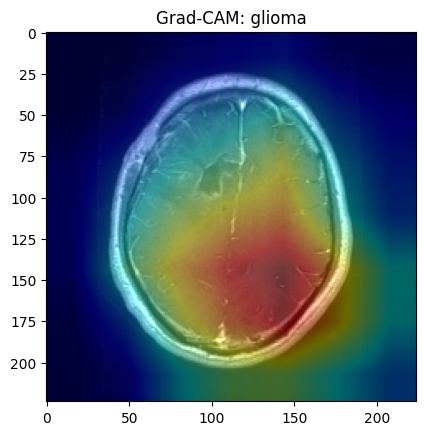


EfficientNet Classification and Grad-CAM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: notumor with confidence 0.4321


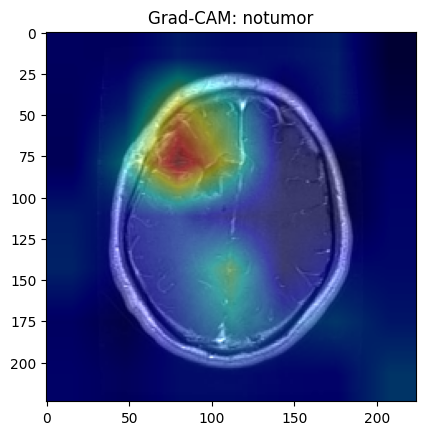

Training and Grad-CAM visualization completed.


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

# Define Constants
IMAGE_SIZE = (224,224) # Standard image size
BATCH_SIZE = 32
NUM_CLASSES = 4
LEARNING_RATE = 0.0001
EPOCHS = 20
SEED = 42  # For reproducibility


# Define Data Paths (Adjust these to your local paths)
TRAIN_DIR = '/content/drive/MyDrive/braintumorDataset/Training/'
TEST_DIR = '/content/drive/MyDrive/braintumorDataset/Testing/'




# Data Preprocessing
def preprocess_image(image_path):

    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image {image_path}")
            return None

        # Check for blur (Laplacian variance).  Adjust threshold as needed.
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        laplacian_variance = cv2.Laplacian(gray, cv2.CV_64F).var()
        if laplacian_variance < 100:  # Threshold for blur detection
            print(f"Warning: Image {image_path} is blurry (variance: {laplacian_variance:.2f}).  Attempting to sharpen.")
            # Apply unsharp masking to try and sharpen (adjust parameters as needed)
            blurred = cv2.GaussianBlur(img, (0, 0), 3)
            img = cv2.addWeighted(img, 1.5, blurred, -0.5, 0) #adjust values for best result

        img = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_AREA)  # Resize
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (important for models)
        img = img.astype('float32') / 255.0  # Normalize
        return img

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None



def data_generator(directory, batch_size, shuffle=True):

    class_names = sorted(os.listdir(directory))
    num_classes = len(class_names)
    image_paths = []
    labels = []

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue  # Skip if it's not a directory
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image_paths.append(image_path)
            labels.append(i)  # Class index

    # Convert to numpy arrays
    image_paths = np.array(image_paths)
    labels = np.array(labels)

    # Shuffle if requested
    if shuffle:
        indices = np.arange(len(image_paths))
        np.random.shuffle(indices)
        image_paths = image_paths[indices]
        labels = labels[indices]

    num_samples = len(image_paths)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_paths = image_paths[offset:offset + batch_size]
            batch_labels = labels[offset:offset + batch_size]

            batch_images = []
            for path in batch_paths:
                img = preprocess_image(path)
                if img is not None:  # Only add if preprocessing was successful
                    batch_images.append(img)
                else:
                    # Handle the error: remove the corresponding label
                    index = np.where(image_paths == path)[0][0]
                    labels = np.delete(labels, index)  # Remove the corrupted images' label
                    image_paths = np.delete(image_paths, index)
            batch_images = np.array(batch_images)

            #One hot encode the batch labels
            batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=num_classes)


            yield batch_images, batch_labels


# Calculate Steps per Epoch
train_samples = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
test_samples = sum([len(files) for r, d, files in os.walk(TEST_DIR)])

train_steps = train_samples // BATCH_SIZE
test_steps = test_samples // BATCH_SIZE

print(f"Train samples: {train_samples}, Test samples: {test_samples}")
print(f"Train steps: {train_steps}, Test steps: {test_steps}")


# Model Creation Functions
def create_xception_model(num_classes):
    """Creates an Xception model with transfer learning."""
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    base_model.trainable = False  # Freeze base model weights

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)  # Add a dense layer
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


def create_efficientnet_model(num_classes):
    """Creates an EfficientNetB0 model with transfer learning."""
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    base_model.trainable = False  # Freeze base model weights

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)  # Add a dense layer
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


# Grad-CAM Visualization
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generates a Grad-CAM heatmap for a given image and model."""
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalize
    return heatmap.numpy()


def visualize_gradcam(img_path, model, last_conv_layer_name,  alpha=0.4):
    """Overlays the Grad-CAM heatmap on the original image."""
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMAGE_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    img_array = preprocess_image(img_path)
    if img_array is None:
        print(f"Skipping GradCAM visualization for {img_path} due to preprocessing error.")
        return None

    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Rescale heatmap to original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # Convert to RGB for matplotlib


    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    return superimposed_img



# Training Function
def train_model(model, model_name, train_generator, validation_generator, train_steps, validation_steps):
    """Trains a given model."""

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'{model_name}_best_model.h5', monitor='val_loss', save_best_only=True)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[early_stopping, model_checkpoint]
    )

    return history

# Classification and Visualization Function
def classify_and_visualize(image_path, model, last_conv_layer_name, class_names):
    """
    Classifies an image, predicts the tumor type, and visualizes with Grad-CAM.

    Args:
        image_path: Path to the input image.
        model: The trained Keras model.
        last_conv_layer_name: Name of the last convolutional layer for Grad-CAM.
        class_names: List of class names.
    """

    img = preprocess_image(image_path)
    if img is None:
        print(f"Error: Could not preprocess image {image_path}. Skipping classification.")
        return

    img_array = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index]

    print(f"Predicted class: {predicted_class_name} with confidence {confidence:.4f}")

    # Generate and visualize Grad-CAM
    gradcam_output = visualize_gradcam(image_path, model, last_conv_layer_name)

    if gradcam_output is not None:
        plt.imshow(gradcam_output)
        plt.title(f"Grad-CAM: {predicted_class_name}")
        plt.show()
    else:
        print("Grad-CAM visualization failed.")


# Main Execution
if __name__ == '__main__':

  # Load Pre-trained Models
    # try:
    #     xception_model = load_model('xception_best_model.h5')  # Assuming the file is in the current directory
    #     print("Xception model loaded successfully.")
    # except Exception as e:
    #     print(f"Error loading Xception model: {e}")
    #     xception_model = None  # Set to None to avoid errors later

    # try:
    #     efficientnet_model = load_model('efficientnet_best_model.h5')  # Assuming the file is in the current directory
    #     print("EfficientNet model loaded successfully.")
    # except Exception as e:
    #     print(f"Error loading EfficientNet model: {e}")
    #     efficientnet_model = None  # Set to None to avoid errors later
    # Prepare Data Generators
    train_data_gen = data_generator(TRAIN_DIR, BATCH_SIZE, shuffle=True)
    test_data_gen = data_generator(TEST_DIR, BATCH_SIZE, shuffle=False) #No need to shuffle test set



    # Xception Training (or Loading)
    xception_model_filepath = '/content/drive/MyDrive/trainedModels/xception_best_model.keras'
    if os.path.exists(xception_model_filepath):
        print(f"Loading existing Xception model from {xception_model_filepath}")
       # xception_model.summary()
        xception_model = load_model(xception_model_filepath)
    else:
        print("Training Xception from scratch...")
        xception_model = create_xception_model(NUM_CLASSES)
        xception_history = train_model(xception_model, "xception", train_data_gen, test_data_gen, train_steps, test_steps, initial_epoch = 0)
        print("Xception training completed.")
        xception_model.save(xception_model_filepath)

    # EfficientNetB0 Training (or Loading)
    efficientnet_model_filepath = '/content/drive/MyDrive/trainedModels/efficientnet_best_model_20.keras'  # Filepath for saving/loading
    if os.path.exists(efficientnet_model_filepath):
        print(f"Loading existing EfficientNet model from {efficientnet_model_filepath}")
       # efficientnet_model.summary()
        efficientnet_model = load_model(efficientnet_model_filepath)
    else:
        print("Training EfficientNet from scratch...")
        efficientnet_model = create_efficientnet_model(NUM_CLASSES)
        efficientnet_history = train_model(efficientnet_model, "efficientnet", train_data_gen, test_data_gen, train_steps, test_steps, initial_epoch = 0)
        print("EfficientNet training completed.")
        efficientnet_model.save(efficientnet_model_filepath)


    #Xception Model
    # xception_model = create_xception_model(NUM_CLASSES)
    # print("Xception Model Summary:")
    # xception_model.summary()
    # xception_history = train_model(xception_model, "xception", train_data_gen, test_data_gen, train_steps, test_steps)



    # EfficientNetB0 Model
    # efficientnet_model = create_efficientnet_model(NUM_CLASSES)
    # print("\nEfficientNetB0 Model Summary:")
    # efficientnet_model.summary()
    # efficientnet_history = train_model(efficientnet_model, "efficientnet", train_data_gen, test_data_gen, train_steps, test_steps)

    # # Define Class Names
    class_names = sorted(os.listdir(TRAIN_DIR)) #Get the classes from the TRAIN_DIR


    # Example Usage: Classify and visualize a single image

    ##Xception example
    example_image_path ='/content/drive/MyDrive/braintumorDataset/Testing/glioma/Te-gl_0016.jpg' # Replace with a valid image path
    last_conv_layer_name_xception = "block14_sepconv2_act"
    print("\nXception Classification and Grad-CAM:")
    classify_and_visualize(example_image_path, xception_model, last_conv_layer_name_xception, class_names)


    ##Effecient net example
    example_image_path = '/content/drive/MyDrive/braintumorDataset/Testing/glioma/Te-gl_0016.jpg' # Replace with a valid image path
    last_conv_layer_name_efficientnet = "top_activation"
    print("\nEfficientNet Classification and Grad-CAM:")
    classify_and_visualize(example_image_path, efficientnet_model, last_conv_layer_name_efficientnet, class_names)


    print("Training and Grad-CAM visualization completed.")

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
import matplotlib.pyplot as plt #import pyplot to display graph

# Define Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
LEARNING_RATE = 0.0001
EPOCHS = 20
SEED = 42
TRAIN_DIR = '/content/drive/MyDrive/braintumorDataset/Training/'
TEST_DIR = '/content/drive/MyDrive/braintumorDataset/Testing/'

# --- Image Processing (Blur Handling) ---
def handle_blur(img):
    """Detects and sharpens blurry images."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    laplacian_variance = cv2.Laplacian(gray, cv2.CV_32F).var()
    if laplacian_variance < 100:  # Threshold for blur detection
        print(f"Warning: Image is blurry (variance: {laplacian_variance:.2f}). Attempting to sharpen.")
        blurred = cv2.GaussianBlur(img, (0, 0), 3)
        img = cv2.addWeighted(img, 1.5, blurred, -0.5, 0)
    return img

# --- Data Augmentation with Custom Preprocessing ---
def preprocess_and_augment(img):
    """Combines blur handling with rescaling and converts to RGB."""
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ensure RGB (important!)
    img = handle_blur(img)  # Apply blur handling
    img = img / 255.0  # Rescale
    return img

# --- Data Generators ---
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_and_augment # Apply custom preprocessing and augmentation
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: preprocess_and_augment(x) # process validation data.
)

validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

# Calculate Steps per Epoch
train_samples = train_generator.samples
test_samples = validation_generator.samples

train_steps = train_samples // BATCH_SIZE
test_steps = test_samples // BATCH_SIZE

print(f"Train samples: {train_samples}, Test samples: {test_samples}")
print(f"Train steps: {train_steps}, Test steps: {test_steps}")

# --- Model Creation ---
def create_efficientnet_model(num_classes):
    """Creates an EfficientNetB0 model with transfer learning and dropout."""
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Unfreeze the last few layers of the base model
    for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers for example
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# --- Training Function ---
# def train_model(model, model_name, train_generator, validation_generator, train_steps, validation_steps,initial_epoch=0, class_weight=None):
#     """Trains a given model."""
#     model.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10), #divide the learning rate to make it lower
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

#     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#     model_checkpoint = ModelCheckpoint(f'{model_name}_best_model_20.keras', monitor='val_loss', save_best_only=True)
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

#     history = model.fit(
#         train_generator,
#         steps_per_epoch=train_steps,
#         epochs=EPOCHS+initial_epochs,
#         validation_data=validation_generator,
#         validation_steps=validation_steps,
#         callbacks=[early_stopping, model_checkpoint, reduce_lr],
#         class_weight=class_weight
#     )
#     return history

def train_model(model, model_name, train_generator, validation_generator, train_steps, validation_steps, initial_epoch=0, class_weight=None):
    """Trains a given model."""
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10), #divide the learning rate to make it lower
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'{model_name}_best_model_20.keras', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(
        # train_generator,
        # steps_per_epoch=train_steps,
        # # Changed line below to use initial_epoch
        # epochs=EPOCHS ,
        # validation_data=validation_generator,
        # validation_steps=validation_steps,
        # callbacks=[early_stopping, model_checkpoint, reduce_lr],
        # class_weight=class_weight
        train_generator,
        steps_per_epoch=train_steps,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        initial_epoch=initial_epoch, # Start from here
        class_weight=class_weight
    )
    return history

# --- Main Execution ---
if __name__ == '__main__':
    efficientnet_model_filepath = '/content/drive/MyDrive/trainedModels/efficientnet_best_model_20.keras'

    #Calculate class weights
    class_names = sorted(os.listdir(TRAIN_DIR))
    num_classes = len(class_names)
    num_samples_per_class = []
    for class_name in class_names:
        class_dir = os.path.join(TRAIN_DIR, class_name)
        num_samples_per_class.append(len(os.listdir(class_dir)))
    num_samples_per_class = np.array(num_samples_per_class)

    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.arange(num_classes),
        y=np.concatenate([[i] * num_samples_per_class[i] for i in range(num_classes)])
    )
    class_weight_dict = dict(zip(range(num_classes), class_weights))
    print("Class Weights:", class_weight_dict)

    # efficientnet_model = create_efficientnet_model(NUM_CLASSES)
    # model_path = '/content/drive/MyDrive/BrainTumorModelCheckpoints/efficientnet_best_model.h5'  # Replace with the correct path
    # efficientnet_model = load_model(model_path)
    # print("Model loaded successfully.")
    # #Train Model:
    # efficientnet_history = train_model(efficientnet_model, "efficientnet", train_data_gen, test_data_gen, train_steps, test_steps, initial_epoch = 10)

    # if os.path.exists(efficientnet_model_filepath):
    #     print(f"Loading existing EfficientNet model from {efficientnet_model_filepath}")
    #     efficientnet_model = load_model(efficientnet_model_filepath)
    #     #Train Model:
    #     efficientnet_history = train_model(efficientnet_model, "efficientnet", train_generator, validation_generator, train_steps, test_steps,initial_epoch=10)
    # else:
    #     print("Training EfficientNet from scratch...")
    #     efficientnet_model = create_efficientnet_model(NUM_CLASSES)
    #     efficientnet_history = train_model(efficientnet_model, "efficientnet", train_generator, validation_generator, train_steps, test_steps, class_weight_dict)
    #     print("EfficientNet training completed.")
    #     efficientnet_model.save(efficientnet_model_filepath)

    if os.path.exists(efficientnet_model_filepath):
        print(f"Loading existing EfficientNet model from {efficientnet_model_filepath}")
        efficientnet_model = load_model(efficientnet_model_filepath)
        initial_epoch = 10
        #Train Model:
        efficientnet_history = train_model(efficientnet_model, "efficientnet", train_generator, validation_generator, train_steps, test_steps, initial_epoch=10, class_weight=class_weight_dict)
    else:
        print("Training EfficientNet from scratch...")
        efficientnet_model = create_efficientnet_model(NUM_CLASSES)
        efficientnet_history = train_model(efficientnet_model, "efficientnet", train_generator, validation_generator, train_steps, test_steps, class_weight_dict)
        print("EfficientNet training completed.")
        efficientnet_model.save(efficientnet_model_filepath)

    # Example Usage: Classify and visualize a single image (You may need to adapt this)
    from tensorflow.keras.preprocessing import image # import
    ##Effecient net example
    example_image_path = '/content/drive/MyDrive/braintumorDataset/Testing/glioma/Te-gl_0010.jpg' # Replace with a valid image path
    last_conv_layer_name_efficientnet = "top_activation"

    # Load and preprocess the image for classification
    img = image.load_img(example_image_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    img_array = img_array / 255.0  # Rescale

    predictions = efficientnet_model.predict(img_array) # Predict
    class_names = sorted(os.listdir(TRAIN_DIR)) #get classes

    predicted_class_index = np.argmax(predictions[0]) #get index of the class
    predicted_class_name = class_names[predicted_class_index] #get the name
    confidence = predictions[0][predicted_class_index]  #confidence

    print(f"\nEfficientNet Classification:")
    print(f"Predicted class: {predicted_class_name} with confidence {confidence:.4f}")

    #Import Grad-CAM functions
    def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        """Generates a Grad-CAM heatmap for a given image and model."""
        grad_model = tf.keras.models.Model(
            [model.inputs],
            [model.get_layer(last_conv_layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        grads = tape.gradient(class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalize
        return heatmap.numpy()


    def visualize_gradcam(img_path, model, last_conv_layer_name,  alpha=0.4):
        """Overlays the Grad-CAM heatmap on the original image."""
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMAGE_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
        img_array = img_array / 255.0  # Rescale

        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        # Rescale heatmap to original image size
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # Convert to RGB for matplotlib


        superimposed_img = heatmap * alpha + img
        superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
        return superimposed_img


    gradcam_output = visualize_gradcam(example_image_path, efficientnet_model, last_conv_layer_name_efficientnet)

    plt.imshow(gradcam_output)
    plt.title(f"Grad-CAM: {predicted_class_name}")
    plt.show()

    print("Training and Grad-CAM visualization completed.")

Found 5732 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Train samples: 5732, Test samples: 1311
Train steps: 179, Test steps: 40
Class Weights: {0: np.float64(1.084784254352763), 1: np.float64(1.070201643017177), 2: np.float64(0.8873065015479876), 3: np.float64(0.9835277968428278)}
Loading existing EfficientNet model from /content/drive/MyDrive/trainedModels/efficientnet_best_model_20.keras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 11/20
  1/179 ━━━━━━━━━━━━━━━━━━━━ 4:06:55 83s/step - accuracy: 0.9062 - loss: 0.2425

KeyboardInterrupt: 

Found 1311 images belonging to 4 classes.
Models loaded successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 348s 9s/step

EfficientNet Classification Report:

              precision    recall  f1-score   support

      glioma       0.93      0.09      0.16       300
  meningioma       0.50      0.71      0.59       306
     notumor       0.66      0.98      0.78       405
   pituitary       0.80      0.64      0.71       300

    accuracy                           0.63      1311
   macro avg       0.72      0.60      0.56      1311
weighted avg       0.71      0.63      0.58      1311


EfficientNet Confusion Matrix:

[[ 27 169  89  15]
 [  2 218  55  31]
 [  0   8 395   2]
 [  0  44  64 192]]


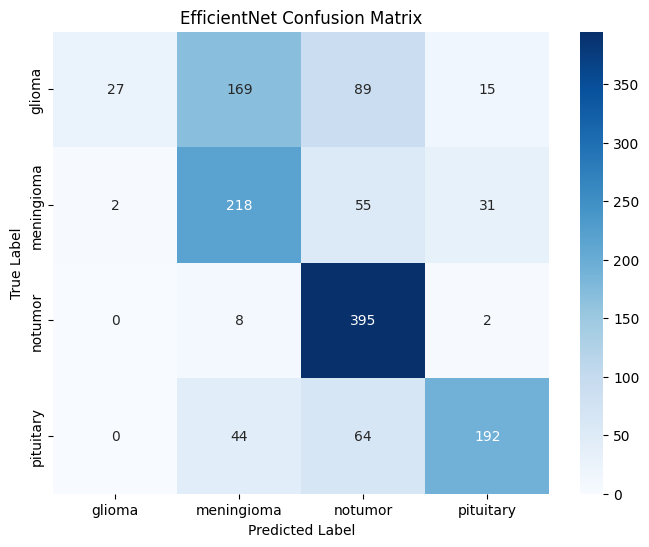

41/41 ━━━━━━━━━━━━━━━━━━━━ 309s 7s/step

Xception Classification Report:

              precision    recall  f1-score   support

      glioma       0.95      0.89      0.92       300
  meningioma       0.84      0.93      0.88       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.96      0.91      0.93       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311


Xception Confusion Matrix:

[[268  28   2   2]
 [ 12 284   2   8]
 [  0   0 405   0]
 [  2  26   0 272]]


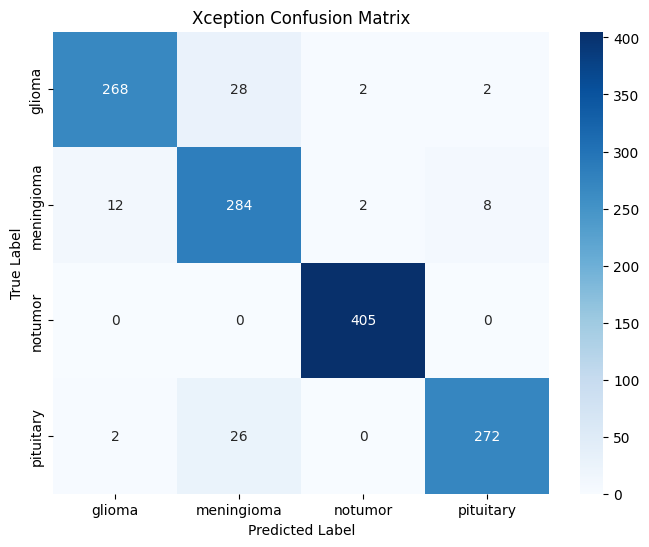

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define Constants (Make sure these match your training settings)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
TRAIN_DIR = '/content/drive/MyDrive/braintumorDataset/Training/'
TEST_DIR = '/content/drive/MyDrive/braintumorDataset/Testing/'

# Prepare Test Data Generator (no augmentation)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important: Keep the order of the data consistent
)

class_names = sorted(os.listdir(TRAIN_DIR)) # Get class names from directory

# Load Models
efficientnet_model_filepath = '/content/drive/MyDrive/trainedModels/efficientnet_best_model_20.keras'
xception_model_filepath = '/content/drive/MyDrive/trainedModels/xception_best_model.keras'

efficientnet_model = load_model(efficientnet_model_filepath)
xception_model = load_model(xception_model_filepath)

print("Models loaded successfully.")

# Function to Evaluate and Print Metrics
def evaluate_model(model, generator, model_name, class_names):
    """Evaluates a model and prints classification report and confusion matrix."""

    # Get true labels and predictions
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1) #Convert probabilities to predicted classes

    # Classification Report
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    print(f"\n{model_name} Confusion Matrix:\n")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Evaluate Models
evaluate_model(efficientnet_model, test_generator, "EfficientNet", class_names)
evaluate_model(xception_model, test_generator, "Xception", class_names)
